In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import colormaps
from pathlib import Path
from scipy.stats import shapiro, wilcoxon, binomtest
from sklearn.metrics import cohen_kappa_score

In [2]:
path_to_recist_measurements = Path.cwd().parent / 'data' / 'final' / "recist_measurements.csv"
path_to_features_train = Path("resources") / "lesions_features_train.csv"
path_to_features_test = Path("resources") / "lesions_features_test.csv"
savefig = False
savecsv = False
save_title = False

## Comparison between RECIST and Automated measurements

In [3]:
def get_features_df(path_to_train_features, path_to_test_features):
    train_df = pd.read_csv(path_to_train_features)
    test_df = pd.read_csv(path_to_test_features)
    df = pd.concat([train_df, test_df])
    return df    

In [4]:
# Read data
recist_measurements_df = pd.read_csv(path_to_recist_measurements)
features_df = get_features_df(path_to_features_train, path_to_features_test)
features_df["label_value"] = features_df["label_value"].astype('int64')
target_measurements_df = recist_measurements_df.merge(
    features_df,
    left_on=['filename', 'lesion_label_value'],
    right_on=['filename', 'label_value'],
    how='inner'
)
display(target_measurements_df)

,patient_id,subset,study_date,study_uuid,uuid,filename,region,final_3d_objects,lesion_label_value,lesion_label_alias,...,label_value,label_description,voxels_count,volume_ml,slices_count,mean_HU,std_HU,major_axis,minor_axis,major_axis_slice_idx
0,1,train,20230426,1.3.51.0.1.1.172.19.3.128.3187796.3187735,1.3.12.2.1107.5.1.4.83504.30000023042612315883...,1.3.12.2.1107.5.1.4.83504.30000023042612315883...,abdomen,1,1,A,...,1,"m,kidney",12334,20.160658,18,29.198233,31.280855,39.513884,26.968684,119
1,1,train,20230426,1.3.51.0.1.1.172.19.3.128.3187796.3187735,1.3.12.2.1107.5.1.4.83504.30000023042612315883...,1.3.12.2.1107.5.1.4.83504.30000023042612315883...,thorax,2,2,B,...,2,"t,lung",4840,2.446292,17,-4.722934,158.250810,24.193537,12.564874,291
2,2,train,20220712,1.3.51.0.1.1.172.19.3.128.3051489.3051428,1.3.12.2.1107.5.1.4.83504.30000022071212080050...,1.3.12.2.1107.5.1.4.83504.30000022071212080050...,abdomen,2,1,A,...,1,"m,liver",5515,7.475294,9,79.737980,16.938963,28.045408,24.976645,155
3,3,test,20210615,1.3.51.0.1.1.172.19.3.128.2857496.2857435,1.3.12.2.1107.5.1.4.83504.30000021061509140333...,1.3.12.2.1107.5.1.4.83504.30000021061509140333...,abdomen,3,3,A,...,3,"n,abdomen",119555,145.312931,37,70.704124,34.270943,148.007803,71.429434,112
4,3,test,20210615,1.3.51.0.1.1.172.19.3.128.2857496.2857435,1.3.12.2.1107.5.1.4.83504.30000021061509140333...,1.3.12.2.1107.5.1.4.83504.30000021061509140333...,abdomen,3,2,B,...,2,"n,abdomen",9302,11.306101,13,63.643196,28.993057,32.593186,15.945229,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,35,test,20210913,1.3.51.0.1.1.172.19.3.128.2891211.2891150,1.3.12.2.1107.5.1.4.83504.30000021091312134713...,1.3.12.2.1107.5.1.4.83504.30000021091312134713...,abdomen,3,1,B,...,1,"m,ovary",35613,44.752974,17,60.593630,37.197500,47.292275,38.097506,37
78,35,test,20210913,1.3.51.0.1.1.172.19.3.128.2891211.2891150,1.3.12.2.1107.5.1.4.83504.30000021091312134713...,1.3.12.2.1107.5.1.4.83504.30000021091312134713...,abdomen,3,4,C,...,4,"m,abdominal wall",2113,2.655295,11,99.596780,31.542658,20.744737,8.462035,80
79,37,train,20230221,1.3.51.0.1.1.172.19.3.128.3156833.3156772,1.3.12.2.1107.5.1.4.83885.30000023022112155417...,1.3.12.2.1107.5.1.4.83885.30000023022112155417...,abdomen,3,1,A,...,1,"m,suprarenal",6727,8.360571,9,34.958675,29.004110,28.884944,22.657977,135
80,37,train,20230221,1.3.51.0.1.1.172.19.3.128.3156833.3156772,1.3.12.2.1107.5.1.4.83885.30000023022112155417...,1.3.12.2.1107.5.1.4.83885.30000023022112155417...,thorax,4,2,A,...,2,"m,lung",1245,0.468262,9,-159.697190,195.136000,10.249570,8.793611,260


In [5]:
# Clean recist measurements
recist_measurements_df["recist_measurement_mm"] = recist_measurements_df["recist_measurement_mm"].astype('float')

In [6]:
# Add diameter length to features dataframe
features_df["diameter_length"] = features_df.apply(lambda x: x["minor_axis"] if x["label_description"].split(',')[0] == 'n' else x['major_axis'], axis=1)
features_df["lesion_type"] = features_df["label_description"].apply(lambda x: x.split(',')[0])
features_df["lesion_location"] = features_df["label_description"].apply(lambda x: x.split(',')[1])

In [7]:
# Get dataframe with target measurements
target_measurements_df = recist_measurements_df.merge(
    features_df,
    left_on=['filename', 'lesion_label_value'],
    right_on=['filename', 'label_value'],
    how='inner'
)
target_measurements_df["lesion_type_label"] = target_measurements_df["lesion_type"].apply(lambda x: "tumor" if x in ["t", "m"] else "adenopathy")

In [8]:
target_measurements_df.describe()

,patient_id,study_date,final_3d_objects,lesion_label_value,recist_measurement_mm,label_value,voxels_count,volume_ml,slices_count,mean_HU,std_HU,major_axis,minor_axis,major_axis_slice_idx,diameter_length
count,82.000000,8.200000e+01,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.00000,82.000000
mean,16.573171,2.021609e+07,15.012195,7.048780,33.365854,7.048780,30694.658537,31.889937,18.853659,36.534573,74.023968,41.156230,26.007203,134.45122,36.105916
std,11.077762,1.158049e+04,25.837810,16.016891,19.615132,16.016891,39430.029279,45.306672,10.458763,64.483349,78.761765,26.365371,14.696454,49.76070,22.007890
min,1.000000,2.019042e+07,1.000000,1.000000,9.000000,1.000000,605.000000,0.468262,4.000000,-220.438190,16.938963,10.249570,8.372263,34.00000,8.847444
25%,8.000000,2.021064e+07,3.000000,2.000000,17.000000,2.000000,4894.000000,3.149119,11.000000,33.535951,25.729586,21.188209,14.646267,110.00000,17.802899
50%,13.000000,2.021103e+07,7.500000,3.000000,27.500000,3.000000,10920.500000,10.307251,16.000000,58.264797,30.416221,32.759602,21.736968,133.00000,29.330443
75%,23.750000,2.023012e+07,13.000000,7.000000,47.500000,7.000000,49338.750000,50.457226,25.750000,74.410528,144.514772,60.562587,35.531493,166.00000,47.327813
max,44.000000,2.023102e+07,135.000000,122.000000,96.000000,122.000000,224495.000000,253.351596,54.000000,105.867940,276.359440,148.007803,71.429434,291.00000,92.608490


In [9]:
# Grouped by lesion label
grouped = target_measurements_df.groupby("label_description").size().reset_index(name="lesions_count")
display(grouped)
grouped = target_measurements_df.groupby("lesion_location").size().reset_index(name="lesions_count")
display(grouped)
grouped = target_measurements_df.groupby("lesion_type_label").size().reset_index(name="lesions_count")
display(grouped)

,label_description,lesions_count
0,"m,abdominal wall",2
1,"m,kidney",1
2,"m,liver",29
3,"m,lung",19
4,"m,ovary",4
5,"m,suprarenal",1
6,"n,abdomen",13
7,"n,aortocaval",1
8,"n,hepatic hilum",3
9,"n,iliac",1


,lesion_location,lesions_count
0,abdomen,13
1,abdominal wall,2
2,aortocaval,1
3,hepatic hilum,3
4,iliac,1
5,inguinal,1
6,kidney,1
7,liver,29
8,lung,22
9,mesenteric,1


,lesion_type_label,lesions_count
0,adenopathy,23
1,tumor,59


In [10]:
# Difference = RECIST - Automated
target_measurements_df["measurement_difference"] = target_measurements_df["recist_measurement_mm"] - target_measurements_df["diameter_length"]
target_measurements_df["absolute_measurement_difference"] = target_measurements_df.apply(lambda x: np.abs(x["recist_measurement_mm"] - x["diameter_length"]), axis=1)

In [11]:
# Color mapping for lesion type labels
cmap = colormaps["tab10"]
unique_labels = target_measurements_df["lesion_type_label"].unique().tolist()
colors = [
    cmap(idx / (len(unique_labels) - 1))
    for idx in range(len(unique_labels))
]
colors = [
    cmap(7 / (len(unique_labels) + 20 - 1)),
    cmap(9 / (len(unique_labels) + 20 - 1))
]
first_color = colors.pop(0)
colors.insert(1, first_color)
color_mapping = {
    key: colors[idx]
    for idx, key in enumerate(unique_labels)
}

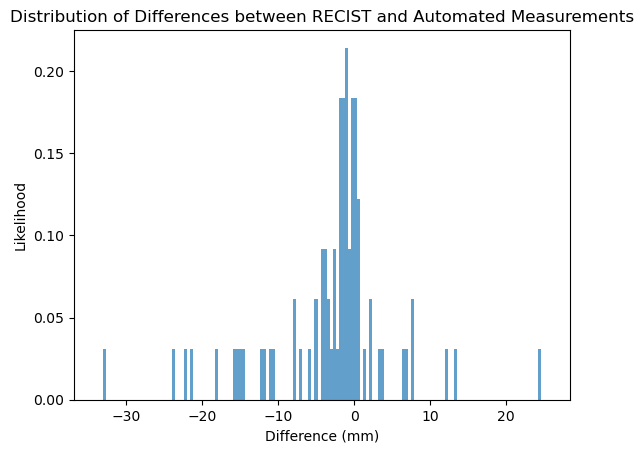

In [12]:
# Probability Distribution of Differences
bins = 150
bin_edges = np.linspace(
    target_measurements_df["measurement_difference"].min() - 1,
    target_measurements_df["measurement_difference"].max() + 1,
    bins
)
hist_values, _ = np.histogram(
    target_measurements_df["measurement_difference"],
    bins=bin_edges,
    density=True
)
plt.bar(
    bin_edges[:-1],
    hist_values,
    width=np.diff(bin_edges),
    alpha=0.7
)
plt.xlabel('Difference (mm)')
plt.ylabel('Likelihood')
plt.title('Distribution of Differences between RECIST and Automated Measurements')
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'difference_distribution_target_measurements.png', bbox_inches='tight', transparent=True)
plt.show()

In [13]:
# Test normality
stat, p = shapiro(target_measurements_df["measurement_difference"])
if p > 0.05:
    print("Differences follow a normal distribution (p =", p, ")")
else:
    print("Differences do NOT follow a normal distribution (p =", p, ")")

Differences do NOT follow a normal distribution (p = 5.197406380830216e-07 )


In [14]:
# Testing difference (distribution of differences symmetric about zero)
stat, p = wilcoxon(target_measurements_df["measurement_difference"])
if p > 0.05:
    print("There's no enough evidence supporting differences are statistically significant (p =", p, ")")
else:
    print("Differences are statistically signicant (p =", p, ")")
print("Wilcoxon test p-value:", p)

Differences are statistically signicant (p = 8.594684439177057e-05 )
Wilcoxon test p-value: 8.594684439177057e-05


In [15]:
target_measurements_df[['measurement_difference', 'absolute_measurement_difference']].describe()

,measurement_difference,absolute_measurement_difference
count,82.000000,82.000000
mean,-2.740063,5.164771
std,8.073626,6.766085
min,-32.691716,0.051930
25%,-3.891841,0.718678
50%,-1.225919,2.242300
75%,0.232394,7.009616
max,24.657285,32.691716


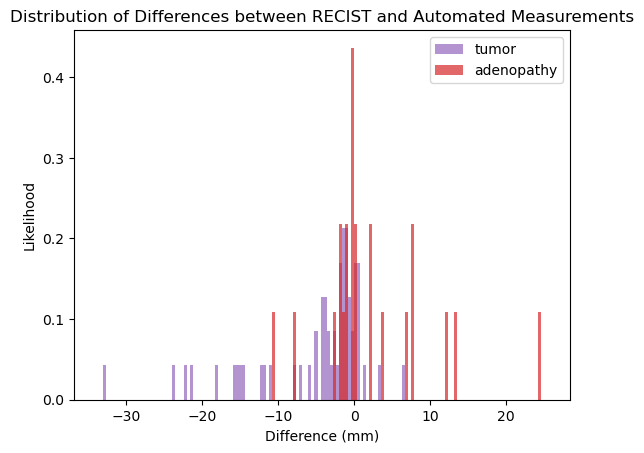

In [16]:
# Probability Distribution of Differences grouped by lesion type (tumor vs adenopathy)
bins = 150
bin_edges = np.linspace(
    target_measurements_df["measurement_difference"].min() - 1,
    target_measurements_df["measurement_difference"].max() + 1,
    bins
)
for label in target_measurements_df["lesion_type_label"].unique().tolist():

    hist_values, _ = np.histogram(
        target_measurements_df[target_measurements_df["lesion_type_label"] == label]["measurement_difference"],
        bins=bin_edges,
        density=True
    )
    plt.bar(
        bin_edges[:-1],
        hist_values,
        width=np.diff(bin_edges),
        alpha=0.7,
        label=label,
        color=color_mapping[label]
    )
plt.xlabel('Difference (mm)')
plt.ylabel('Likelihood')
plt.title('Distribution of Differences between RECIST and Automated Measurements')
plt.legend()
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'difference_distribution_target_measurements_grouped.png', bbox_inches='tight', transparent=True)
plt.show()

In [17]:
# Save dataframes
if savecsv:
    target_measurements_df.to_csv(Path.cwd() / "results" / "target_measurements.csv", index=False)

In [18]:
target_measurements_df.groupby('lesion_type_label').describe()[["measurement_difference", "absolute_measurement_difference"]]

measurement_difference                                 \
                                   count      mean       std        min   
lesion_type_label                                                         
adenopathy                          23.0  2.471222  7.364054 -10.429434   
tumor                               59.0 -4.771580  7.449480 -32.691716   

                                                            \
                        25%       50%       75%        max   
lesion_type_label                                            
adenopathy        -0.890301  0.152556  5.550205  24.657285   
tumor             -5.172292 -1.606765 -0.432378   6.874154   

                  absolute_measurement_difference                      \
                                            count      mean       std   
lesion_type_label                                                       
adenopathy                                   23.0  4.776667  6.063015   
tumor                                        59.0  5.316065  7.064522   

                                                                      
                        min       25%       50%       75%        max  
lesion_type_label                                                     
adenopathy         0.051930  0.568285  2.218653  7.703977  24.657285  
tumor              0.189125  0.829832  2.346865  6.139683  32.691716

In [19]:
# Test for differences grouped by lesion type
for lesion in target_measurements_df["lesion_type_label"].unique().tolist():
    stat, p = wilcoxon(target_measurements_df[target_measurements_df["lesion_type_label"] == lesion]["measurement_difference"])
    print(f"Testing for {lesion}")
    print(30 * '-')
    if p > 0.05:
        print("There's no enough evidence supporting differences are statistically significant (p =", p, ")")
    else:
        print("Differences are statistically signicant (p =", p, ")")
    print("Wilcoxon test p-value:", p)
    print('\n')

Testing for tumor
------------------------------
Differences are statistically signicant (p = 1.0301527489096879e-07 )
Wilcoxon test p-value: 1.0301527489096879e-07


Testing for adenopathy
------------------------------
There's no enough evidence supporting differences are statistically significant (p = 0.2725830078125 )
Wilcoxon test p-value: 0.2725830078125




In [20]:
target_measurements_df["measurement_difference"].shape

(82,)

In [21]:
# Testing under/over estimation grouped by type of lesion
for lesion in target_measurements_df["lesion_type_label"].unique().tolist():
    num_positive = target_measurements_df[
    (target_measurements_df["lesion_type_label"] == lesion) &
    (target_measurements_df["measurement_difference"] > 0)
    ].size
    num_total = target_measurements_df[
    target_measurements_df["lesion_type_label"] == lesion
    ].size
    over_result = binomtest(
        num_positive,
        num_total,
        p=0.5,
        alternative='greater'
    )
    under_result = binomtest(
        num_positive,
        num_total,
        p=0.5,
        alternative='less'
    )
    print(f"Testing for {lesion}")
    print(30 * '-')
    print("Overestimation:")
    if over_result.pvalue < 0.05:
        print(f"RECIST measurements systematically overestimates automated measurements (p = {over_result.pvalue})")
    else:
        print(f"No significant systematic trend is found (p = {over_result.pvalue}).")
    print("\nUnderestimation:")
    if under_result.pvalue < 0.05:
        print(f"RECIST measurements systematically underestimates automated measurements (p = {under_result.pvalue})")
    else:
        print(f"No significant systematic trend is found (p = {under_result.pvalue}).")
    print('\n')

Testing for tumor
------------------------------
Overestimation:
No significant systematic trend is found (p = 1.0).

Underestimation:
RECIST measurements systematically underestimates automated measurements (p = 2.1033388028868316e-154)


Testing for adenopathy
------------------------------
Overestimation:
RECIST measurements systematically overestimates automated measurements (p = 0.0005287086660178948)

Underestimation:
No significant systematic trend is found (p = 0.9996016319463108).




## RECIST classification

In [22]:
tumoral_burden_df = target_measurements_df.groupby(["patient_id", "study_date"])["recist_measurement_mm"].sum().reset_index(name="recist_tumoral_burden")
tumoral_burden_df["automated_tumoral_burden"] = target_measurements_df.groupby(["patient_id", "study_date"])["diameter_length"].sum().reset_index(name="automotated_tumoral_burden")["automotated_tumoral_burden"]
display(tumoral_burden_df)

,patient_id,study_date,recist_tumoral_burden,automated_tumoral_burden
0,1,20230426,64.0,63.707421
1,2,20220712,27.0,28.045408
2,3,20210615,101.0,105.471951
3,3,20210825,93.0,74.724740
4,3,20211027,93.0,82.939293
5,5,20210527,28.0,31.066164
6,7,20210526,57.0,58.118349
7,7,20210802,57.0,63.860702
8,7,20211007,72.0,81.027460
9,8,20220825,89.0,82.076411


In [23]:
output_classes = []
study_dates = tumoral_burden_df.groupby(["patient_id"])["study_date"].size().reset_index(name="date_counts")
cleaned_study_dates = study_dates[study_dates["date_counts"] > 1]
subset_df = tumoral_burden_df[tumoral_burden_df["patient_id"].isin(cleaned_study_dates["patient_id"].unique().tolist())].copy()
subset_df.sort_values(by=["patient_id", "study_date"], inplace=True)
display(subset_df)

,patient_id,study_date,recist_tumoral_burden,automated_tumoral_burden
2,3,20210615,101.0,105.471951
3,3,20210825,93.0,74.724740
4,3,20211027,93.0,82.939293
6,7,20210526,57.0,58.118349
7,7,20210802,57.0,63.860702
8,7,20211007,72.0,81.027460
9,8,20220825,89.0,82.076411
10,8,20221012,63.0,62.727004
11,8,20221129,54.0,53.079196
12,8,20230117,45.0,46.528240


In [24]:
classifications = []
for patient_id in subset_df["patient_id"].unique().tolist():
    studies_subset_df = subset_df[subset_df["patient_id"] == patient_id]
    difference_df = subset_df[subset_df["patient_id"] == patient_id].diff()
    difference_df.dropna(inplace=True)
    difference_df["patient_id"] = subset_df[subset_df["patient_id"] == patient_id]["patient_id"].iloc[1:]
    difference_df["study_date"] = subset_df[subset_df["patient_id"] == patient_id]["study_date"].iloc[1:]
    # Set initial values
    recist_baseline_date = studies_subset_df["study_date"].iloc[0]
    recist_min_burden = studies_subset_df["recist_tumoral_burden"].iloc[0]
    automated_baseline_date = studies_subset_df["study_date"].iloc[0]
    automated_min_burden = studies_subset_df["automated_tumoral_burden"].iloc[0]
    for idx, (_, row) in enumerate(difference_df.iterrows()):
        # RECIST
        recist_current_burden = studies_subset_df["recist_tumoral_burden"].iloc[idx+1]
        recist_percentual_variation = 100 * (recist_current_burden - recist_min_burden) / recist_min_burden
        if recist_percentual_variation < -30.0:
            recist_classification = "PR"
        elif recist_percentual_variation > 20.0:
            recist_classification = "PD"
        else:
            recist_classification = "SD"
        # Automated
        automated_current_burden = studies_subset_df["automated_tumoral_burden"].iloc[idx+1]
        automated_percentual_variation = 100 * (automated_current_burden - automated_min_burden) / automated_min_burden
        if automated_percentual_variation < -30.0:
            automated_classification = "PR"
        elif automated_percentual_variation > 20.0:
            automated_classification = "PD"
        else:
            automated_classification = "SD"
        classifications.append({
            "patient_id": patient_id,
            "current_date": str(int(row["study_date"])),
            "recist_baseline_date": recist_baseline_date,
            "recist_current_burden": recist_current_burden,
            "recist_baseline_burden": recist_min_burden,
            "recist_burden_difference": recist_current_burden - recist_min_burden,
            "recist_burden_percentual_variation": recist_percentual_variation,
            "recist_classification": recist_classification,
            "automated_baseline_date": automated_baseline_date,
            "automated_current_burden": automated_current_burden,
            "automated_baseline_burden": automated_min_burden,
            "automated_burden_difference": automated_current_burden - automated_min_burden,
            "automated_burden_percentual_variation": automated_percentual_variation,
            "automated_classification": automated_classification
        })
        if recist_current_burden < recist_min_burden:
            recist_min_burden = recist_current_burden
            recist_baseline_date = studies_subset_df["study_date"].iloc[idx+1]

classifications_df = pd.DataFrame(classifications)
display(classifications_df)

,patient_id,current_date,recist_baseline_date,recist_current_burden,recist_baseline_burden,recist_burden_difference,recist_burden_percentual_variation,recist_classification,automated_baseline_date,automated_current_burden,automated_baseline_burden,automated_burden_difference,automated_burden_percentual_variation,automated_classification
0,3,20210825,20210615,93.0,101.0,-8.0,-7.920792,SD,20210615,74.724740,105.471951,-30.747211,-29.152026,SD
1,3,20211027,20210825,93.0,93.0,0.0,0.000000,SD,20210615,82.939293,105.471951,-22.532658,-21.363650,SD
2,7,20210802,20210526,57.0,57.0,0.0,0.000000,SD,20210526,63.860702,58.118349,5.742353,9.880447,SD
3,7,20211007,20210526,72.0,57.0,15.0,26.315789,PD,20210526,81.027460,58.118349,22.909111,39.418034,PD
4,8,20221012,20220825,63.0,89.0,-26.0,-29.213483,SD,20220825,62.727004,82.076411,-19.349408,-23.574871,SD
5,8,20221129,20221012,54.0,63.0,-9.0,-14.285714,SD,20220825,53.079196,82.076411,-28.997215,-35.329536,PR
6,8,20230117,20221129,45.0,54.0,-9.0,-16.666667,SD,20220825,46.528240,82.076411,-35.548171,-43.311069,PR
7,12,20190703,20190415,38.0,36.0,2.0,5.555556,SD,20190415,37.203114,37.439574,-0.236460,-0.631577,SD
8,12,20191030,20190415,38.0,36.0,2.0,5.555556,SD,20190415,52.747068,37.439574,15.307494,40.885867,PD
9,13,20210819,20210610,131.0,167.0,-36.0,-21.556886,SD,20210610,165.420145,181.429071,-16.008926,-8.823793,SD


In [25]:
classifications_df[["recist_classification", "automated_classification"]]

,recist_classification,automated_classification
0,SD,SD
1,SD,SD
2,SD,SD
3,PD,PD
4,SD,SD
5,SD,PR
6,SD,PR
7,SD,SD
8,SD,PD
9,SD,SD


In [26]:
classifications_kappa = cohen_kappa_score(
    classifications_df["recist_classification"],
    classifications_df["automated_classification"]
)
print(f"Cohen's Kappa agreement between Manual RECIST and Automated classification: {classifications_kappa}")

Cohen's Kappa agreement between Manual RECIST and Automated classification: 0.206896551724138


In [27]:
classifications_df[classifications_df["recist_classification"] == classifications_df["automated_classification"]].shape

(18, 14)

In [28]:
if savecsv:
    classifications_df.to_csv(
        Path.cwd() / "results" / "recist_and_automated_classifications.csv",
        index=False
    )

## Highlights
- Total of RECIST measurements: 61.
- Difference between manual RECIST and automated measurements **are statiscally significant**, meaning the distribution of differences is not symmetric about zero (p =  9.4e-4, Wilcoxon signed-rank test). **Observed Mean is **-3.8 +- 14.6** with a Median equal to **-3.0**.
- RECIST measurements of tumoral lesions tends to underestimate automated diameter length (p = 4.167160709591147e-181, signed-rank test, 40 lesions).
- RECIST measurements of adenopathies tends to overestimate automated diameter length (p = 4.238640072649887e-09, signed-rank test, 21 lesions).
- From the whole set of RECIST measurements, 17 tumor burden assessments (comparisons to baseline) were obtained. **In only 10/17 (58.8%) classifications manual RECIST and automated approach resulted in the same response** (Progressive Disease, Partial Responde, or Stable Disease). **The agreement between both measurements is just slight** (Cohen's Kappa k=0.09).
- Observations:
    - The difference between manual RECIST and automated measurements is statiscally significant. However, are small differences a neccessary condition to reach agreement in RECIST classifications? I'd say it's sufficient, but not required.
  